In [1]:
library(Seurat)
library(SeuratObject)
library(dplyr)
library(ggplot2)
library(tibble)
library(patchwork)

load("../../MF1/overview/load_files/Macaque.developing.seurat.Rdata")
mac$subtype <- gsub("InN HMX1", "InN HMX2", mac$subtype)

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
## Subset to patterning center related cell types (organizer & early subtypes)
cls_order <- c("PC FGF17", "IPC FGF17", "Neu TAGLN3 ONECUT2", 
               "Ant SFRP1", "AntVen NKX2-1 NKX6-2", "AntVen NKX2-1 LMO1", 
               "inIPC ASCL1 DLX1", "InN LHX6 MAF", "InN LHX8 ZIC1", "InN GNRH1", "InN HMX2", 
               "GE RG NKX2-1 DLK1", "GE RG NKX2-1 OLIG1", "Pos NKX2-1 RAX", 
               "PC RSPO3", "PC TTR", "IPC RSPO3 NEUROG1", "IPC RSPO3 NHLH1", "CR TP73", 
               "PC SFRP2", "inIPC ASCL1 SFRP2", "InN SFRP2 MEIS2", "PC TCF7L2", "IPC TCF7L2", 
               "Neu TAGLN3 NRN1", "Cls LHX9 EBF1", "Cls GSX2 B3GAT2", "Cls FGF17 LGI1", "Cls RSPO3 SOX1")
print(setdiff(cls_order, mac@meta.data$subtype))
seu <- subset(mac, subtype %in% cls_order)

character(0)


`summarise()` has grouped output by 'subtype'. You can override using the
`.groups` argument.
Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”
`summarise()` has grouped output by 'subtype'. You can override using the
`.groups` argument.


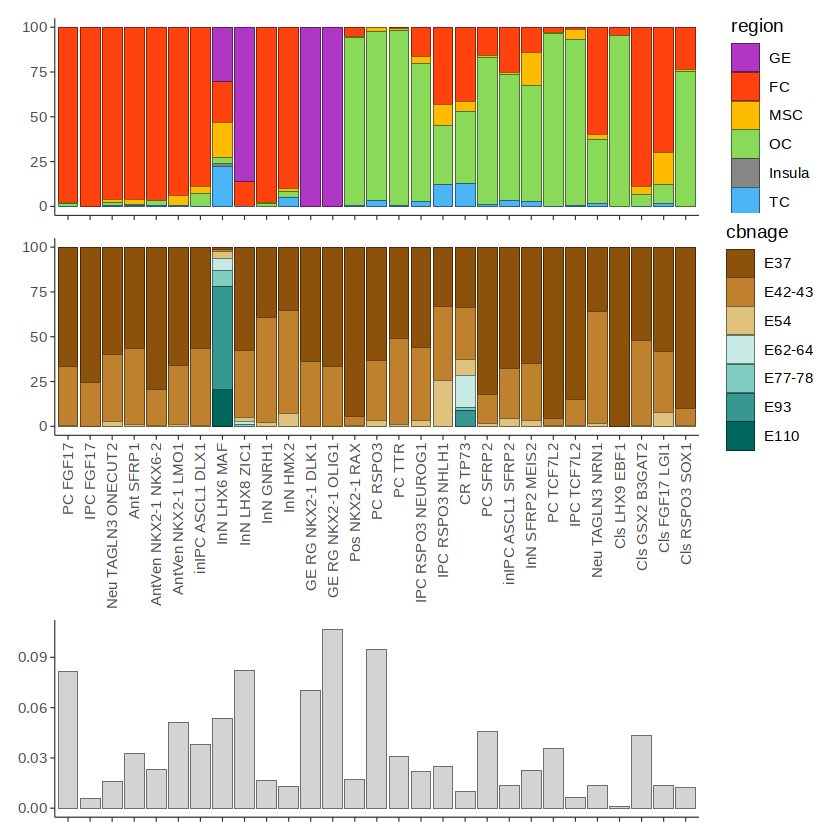

In [3]:
fmeta <- seu@meta.data
split.by <- "region"
reg_cols <- c("#FF420E", "#FFBB00", "#4CB5F5", "#89DA59", "#878787", "#B037C4") %>% 
            setNames(., c("FC", "MSC", "TC", "OC", "Insula", "GE"))
age_cols <- c("#8c510a", "#bf812d", "#dfc27d", "#c7eae5", "#80cdc1", "#35978f", "#01665e") %>% 
            setNames(., c("E37", "E42-43", "E54", "E62-64", "E77-78", "E93", "E110"))
plist <- lapply(c("region", "cbnage"), function(split.by) {
            plot_data <- fmeta %>%
                rownames_to_column("cell") %>%
                group_by(subtype, !!sym(split.by)) %>%
                summarize(size = n()) %>%
                ungroup() %>% 
                group_by(subtype) %>%
                mutate(size = size * 100/sum(size)) %>%
                ungroup() %>%
                mutate(subtype = factor(subtype, levels = cls_order)) %>%
                mutate(!!sym(split.by) := factor(!!sym(split.by), 
                                                 levels = switch(split.by, 
                                                                 region = c("GE", "FC", "MSC", "OC", "Insula", "TC"), 
                                                                 cbnage = c("E37", "E42-43", "E54", "E62-64", 
                                                                           "E77-78", "E93", "E110"))))
            
            cols_use <- switch(split.by, cbnage = age_cols, region = reg_cols)
            p <- ggplot(plot_data, aes(x = subtype, y = size)) +
                geom_bar(aes(fill = !!sym(split.by)), 
                         color = "black", position = position_stack(reverse = FALSE), 
                         stat = "identity", lwd = 0.1) +
                ##lemon::coord_capped_cart(bottom='both', left='both') +
                theme_classic() + 
                scale_fill_manual(values = cols_use) +
                labs(y = "Cluster", x = "Sample Ratio")

            if (split.by == "cbnage"){
                p <- p + 
                    theme(axis.line=element_line(size = 0.2), 
                          axis.ticks=element_line(size = 0.25), 
                          axis.text.x = element_text(size = rel(1), angle = 90, hjust = 1, vjust = 0.5), 
                          axis.title = element_blank())
            } else {
                p <- p + 
                    theme(axis.line=element_line(size = 0.2), 
                          axis.ticks=element_line(size = 0.25), 
                          axis.text.x = element_blank(), 
                          axis.title = element_blank())
            }
            p
            })



## Cluster size
size_data <- fmeta %>%
                filter(cbnage %in% c("E37", "E42-43")) %>%
                group_by(subtype) %>%
                summarize(ncells = n()) %>%
                ungroup() %>%
                mutate(ratio = ncells/sum(ncells)) %>%
                mutate(subtype = factor(subtype, levels = cls_order))
p <- ggplot(size_data, aes(x = subtype, y = ratio)) +
                geom_bar(fill = "lightgrey", color = "black", stat = "identity", lwd = 0.1) +
                ## lemon::coord_capped_cart(bottom='both', left='both') +
                theme_classic() + 
                labs(y = "Cluster", x = "Sample Ratio") +
                theme(axis.line=element_line(size = 0.2), 
                      axis.ticks=element_line(size = 0.25), 
                      axis.text.x = element_blank(), 
                      axis.title = element_blank())
p_anno <- patchwork::wrap_plots(c(plist, list(p)), nrow = 3, ncol = 1)
p_anno

In [4]:
pdf(paste0("./report/", "PAT-related_age_region_contribution_v2.pdf"), width = 10, height = 9)
print(p_anno)
dev.off()

png 
  2

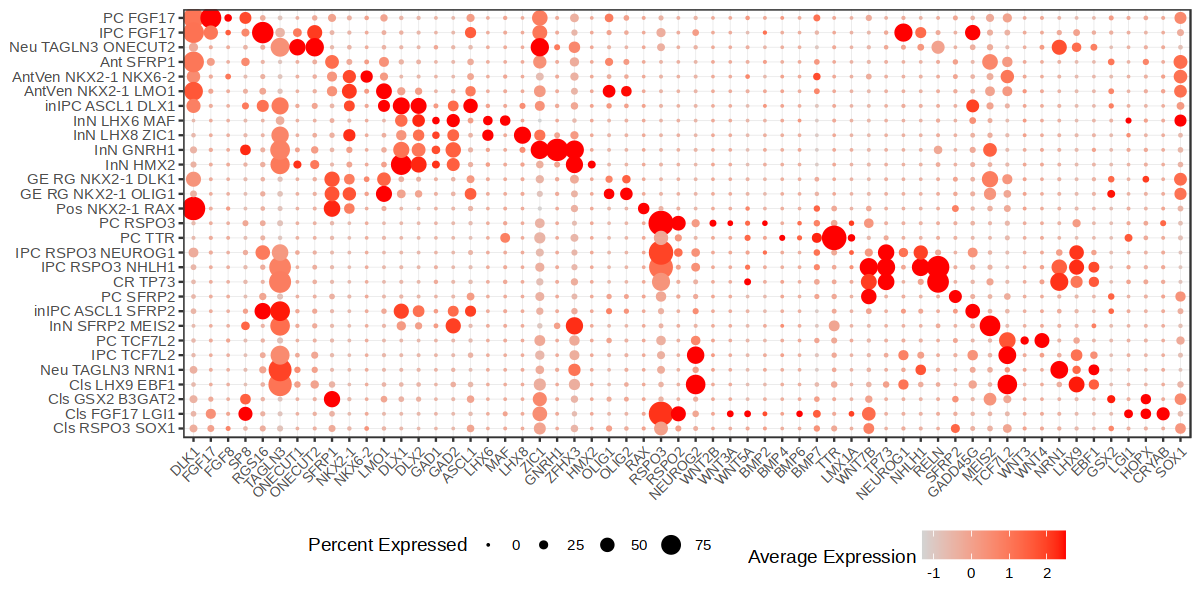

In [5]:
features <- c("DLK1", "FGF17", "FGF8", "SP8", "RGS16", "TAGLN3", 
              "ONECUT1", "ONECUT2", "SFRP1", "NKX2-1", "NKX6-2", 
              "LMO1", "DLX1", "DLX2", "GAD1", "GAD2", "ASCL1", 
              "LHX6", "MAF", "LHX8", "ZIC1", "GNRH1", "ZFHX3", "HMX2", 
              "OLIG1", "OLIG2", "RAX", "RSPO3", "RSPO2", 
              "NEUROG2", "WNT2B", "WNT3A", "WNT5A", "BMP2", "BMP4", "BMP6", "BMP7", "TTR", "LMX1A", "WNT7B", 
              "TP73", "NEUROG1", "NHLH1", "RELN", "SFRP2", "GADD45G", "MEIS2", 
              "TCF7L2", "WNT3", "WNT4", "NRN1", "LHX9", "EBF1", "GSX2", "LGI1", "HOPX", "CRYAB", "SOX1")
Idents(seu) <- "subtype"
p_exp <- DotPlot(object = seu, features = features, cols = c("lightgrey", "red"), dot.scale = 6, dot.min = 0) + 
        theme_bw() + 
        RotatedAxis() + 
        scale_y_discrete(limits = rev(cls_order))+
        theme(axis.text.y = element_text(size = rel(1)), 
              axis.text.x = element_text(size = rel(0.9)), 
              legend.position = "bottom", 
              axis.title = element_blank(), 
              panel.grid.major= element_line(size = 0.2), 
              panel.grid.minor= element_line(size = 0.2))
options(repr.plot.width=10, repr.plot.height=5, res = 300)
p_exp

In [6]:
pdf(paste0("./report/", "PAT-related_marker_dot_expr_v2.pdf"), width = 9, height = 5, useDingbats = FALSE)
print(p_exp)
dev.off()

png 
  2

In [7]:
sessionInfo()

R version 4.2.2 (2022-10-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server 7.9 (Maipo)

Matrix products: default
BLAS/LAPACK: /gpfs/gibbs/pi/sestan.ycga/sm2726/conda_envs/scmultiome/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] patchwork_1.1.2    tibble_3.1.8       ggplot2_3.4.1      dplyr_1.1.0       
[5] SeuratObject_4.1.3 Seurat_4.3.0      

loaded via a namespace (and not attached):
  [1] Rtsne_0.16             colorspace_2.1-0       deldir_1.0-6          
  [4] ellipsis_0.3